In [1]:
!python --version

Python 3.13.5


In [2]:
import gc
import os
from PIL import Image

import torch
from torch.nn import (Conv2d, Dropout, Linear)
from torch.nn.functional import (relu, max_pool2d, avg_pool2d)
import torchvision

import numpy as np
np.random.seed(2025 - 6 - 20)
from numpy.typing import NDArray

import matplotlib.pyplot as plt

In [3]:
os.listdir(r"../cowpea/"); # images are named 1 to 100 <num>.TIF

In [6]:
# what does a convolution kernel do to an image???

image = np.array(Image.open(f"../cowpea/{np.random.randint(low=1, high=100)}.TIF"))

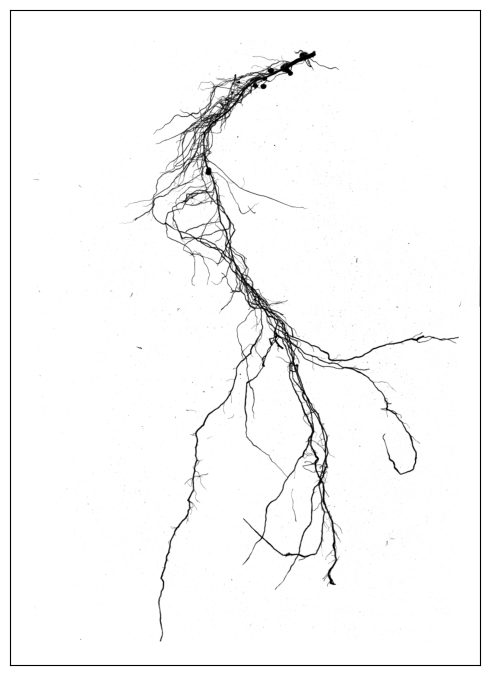

In [7]:
fig, axes = plt.subplots()
fig.set_size_inches(5, 7.5)
axes.imshow(image)
axes.set_xticks([])
axes.set_yticks([])
plt.tight_layout()
plt.show()

In [9]:
image.reshape(3, 3078, 2207)

array([[[ 53,  53,  53, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ...,  51,  44,  44],
        [ 44,  53,  53, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ...,  70,  39,  39],
        [ 39,  44,  44, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 233, 233, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 252, 252, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]]],
      shape=(3, 3078, 2207), dtype=uint8)

In [89]:
def rgb_matrix_to_tensor(image: NDArray[np.uint8]) -> torch.FloatTensor:
    """
    input is expected to be a H x W matrix made of [R, G, B] channels
    i.e (H, W, 3) to (3, H, W)
    """

    height, width, nchannels = image.shape
    if nchannels != 3: # RGB channels expected!!!
        raise RuntimeError(f"Only images using the standard RGB channel pixels are supported! Expected 3, but got {nchannels} channels!")
    
    result = torch.tensor(np.array(np.unstack(image, axis=-1)), # split the image into 3 matrixes for each R, G and B channels
                       dtype=torch.float32)
    
    assert (result.shape[0] == 3) and (result.shape[1] == height) and (result.shape[2] == width), "Shape mismatches between input array and result tensor!"
    return result

def tensor_to_rgb_matrix(tensor: torch.FloatTensor) -> torch.FloatTensor:
    """
    transforms a tensor of R, G & B matrices into a matrix of [R, G, B] pixels
    i.e from (3, H, W) to (H, W, 3)
    """
    
    return np.stack(tensor, axis=-1)

@torch.no_grad
def scale_to_standard_rgb_channels(tensor: torch.FloatTensor|NDArray[np.floating]) -> torch.IntTensor|NDArray[np.uint8]:
    """
    scales a tensor or array of floats with unknown bounds into a tensor or array of uint8s with an inclusive range [0, 255]
    """
    
    tensor += abs(tensor.min()) # probably a negative value, hence the abs()
    tensor /= tensor.max() # downscale to [0.00, 1.00]
    tensor *= 255 # upscale to RGB channel max 255
    return tensor.type(torch.uint8) if isinstance(tensor, torch.Tensor) else tensor.astype(np.uint8)

In [90]:
with torch.no_grad():
    convolved = torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(10, 10))(rgb_matrix_to_tensor(image))

In [91]:
convolved.shape, image.shape

(torch.Size([3, 3069, 2198]), (3078, 2207, 3))

In [92]:
tensor_to_rgb_matrix(scale_to_standard_rgb_channels(convolved)).min(), tensor_to_rgb_matrix(scale_to_standard_rgb_channels(convolved)).max()

(np.uint8(0), np.uint8(255))

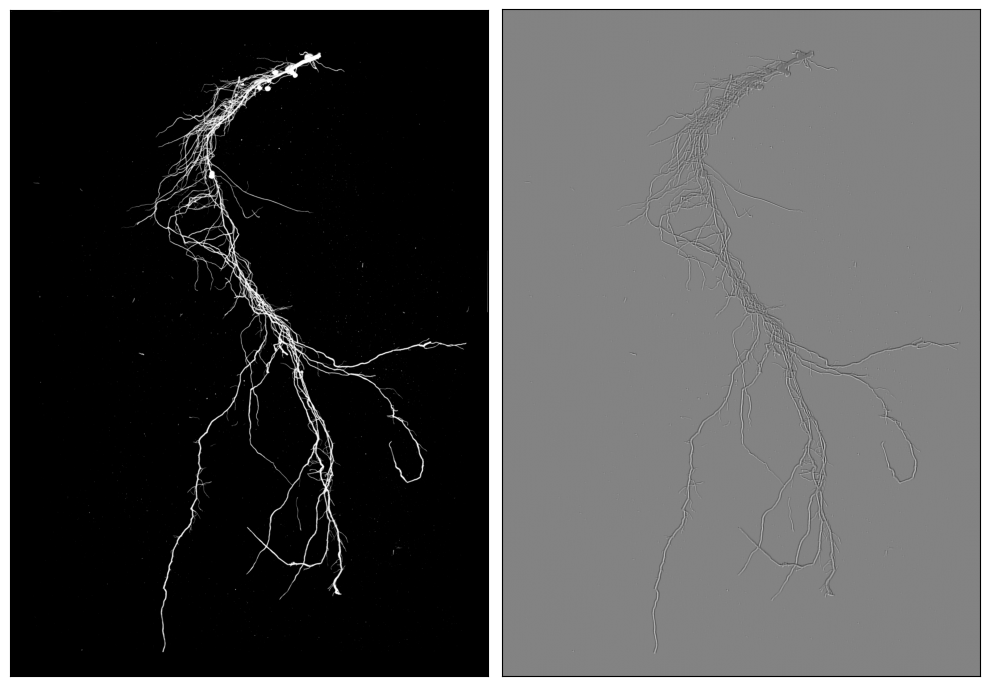

In [93]:
fig, (axes_l, axes_r) = plt.subplots(ncols=2)
fig.set_size_inches(10, 7.5)

axes_l.imshow(image.mean(axis=2), cmap=plt.cm.binary)
axes_l.set_xticks([])
axes_l.set_yticks([])

axes_r.imshow(scale_to_standard_rgb_channels(tensor_to_rgb_matrix(convolved)).mean(axis=2), cmap=plt.cm.binary)
axes_r.set_xticks([])
axes_r.set_yticks([])

plt.tight_layout()
plt.show()

In [105]:
with torch.no_grad():
    exploded = Conv2d(in_channels=3, out_channels=12, kernel_size=(4, 4))(rgb_matrix_to_tensor(image))

In [107]:
exploded.shape

torch.Size([12, 3075, 2204])

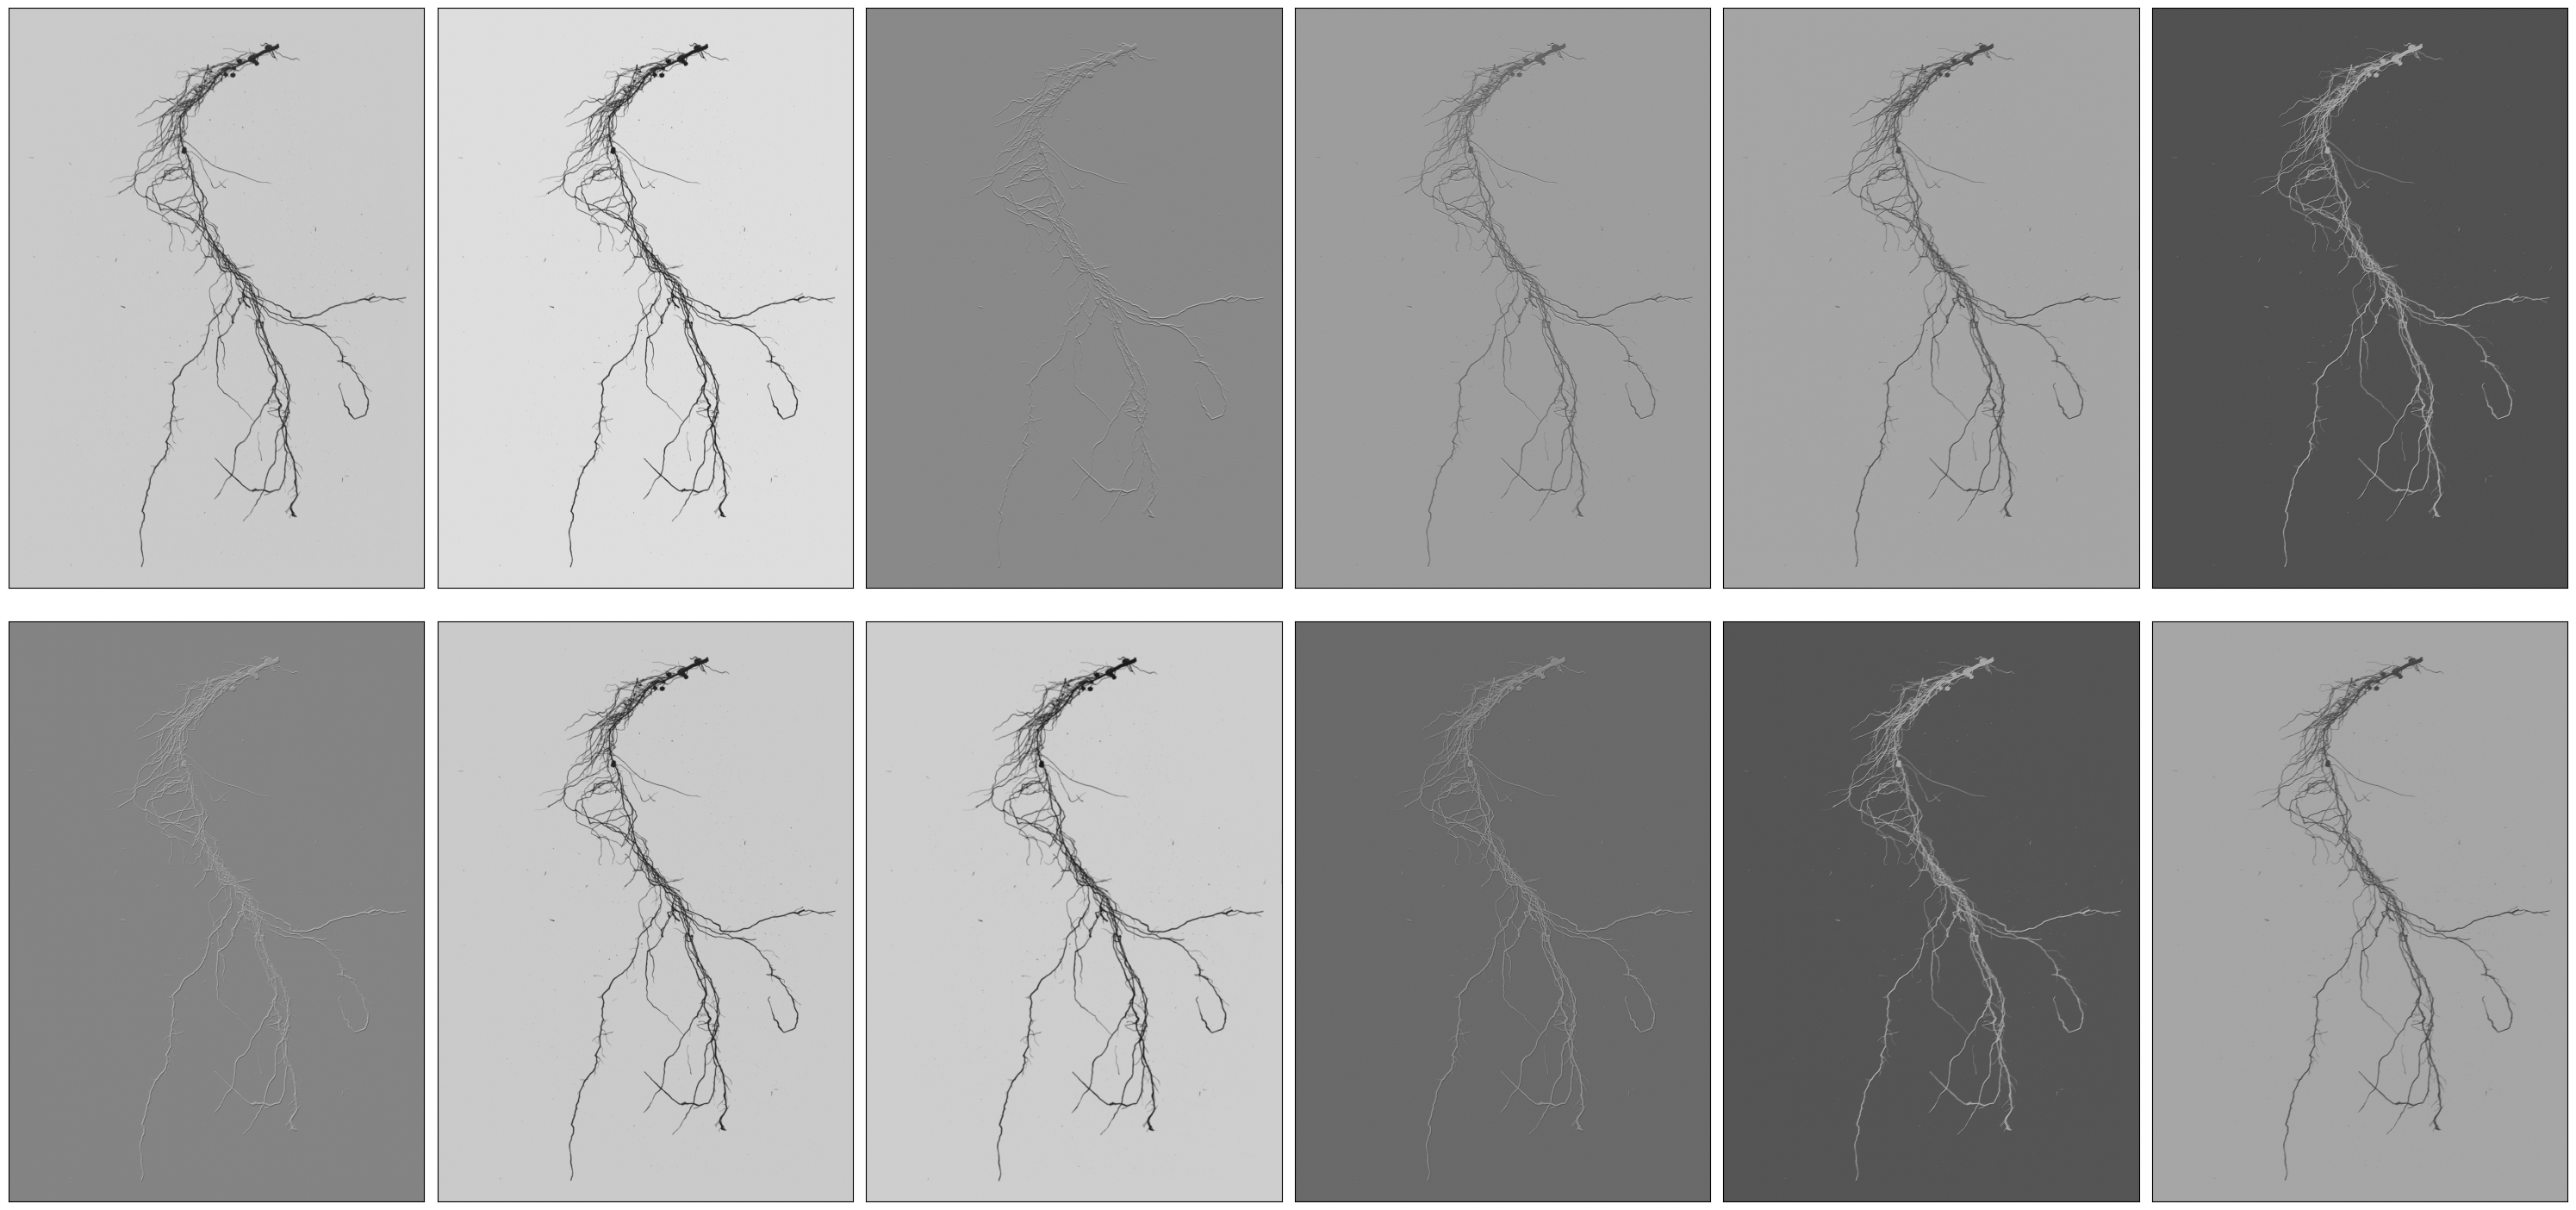

In [115]:
# plot all the 12 layers

fig, axes = plt.subplots(nrows=2, ncols=6)
fig.set_size_inches(30, 15)

for (i, axis) in enumerate(axes.flatten()):
    axis.imshow(exploded[i], cmap=plt.cm.binary_r)
    axis.set_xticks([])
    axis.set_yticks([])

plt.tight_layout()
plt.show()

In [103]:
# imitate a forward pass

with torch.no_grad():
    conv1 = Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), stride=1)
    conv2 = Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1)
    dropout1 = Dropout(0.25)
    dropout2 = Dropout(0.5)
    fc1 = Linear(in_features=9216, out_features=128)
    fc2 = Linear(in_features=128, out_features=10)
    
    step_0 = conv1(rgb_matrix_to_tensor(image))
    step_1 = relu(step_0)
    step_2 = conv2(step_1)
    step_3 = relu(step_2)
    step_4 = max_pool2d(step_3, 2)
    step_5 = dropout1(step_4)
    step_6 = torch.flatten(step_5, 1)
    step_7 = fc1(step_6)
    step_8 = relu(step_7)
    step_9 = dropout2(step_8)
    step_10 = fc2(step_9)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x1692237 and 9216x128)

In [98]:
step_0.shape

torch.Size([32, 3076, 2205])

In [88]:
[gc.collect(gen) for gen in range(3)]

[0, 0, 0]